In [1]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
print(np.__version__)

import matplotlib
from matplotlib import pyplot as plt
print(matplotlib.__version__)

2023-01-03 00:15:12.798492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0
1.21.5
3.5.2


## Dataset creation

Let's take a quick look at what this input and output looks like.

In [5]:
## svn co https://github.com/chenyk1990/mldata/trunk/salt/tgs2d ./
## unzip first

# !pip install opencv-python
import cv2
import os
labels_folder = "/Users/chenyk/chenyk.mldata/salt/tgs2d/train/masks/"
images_folder = "/Users/chenyk/chenyk.mldata/salt/tgs2d/train/images/"

import glob
X = []
Y = []
for filename in glob.glob(images_folder + "*.png"):
    img = cv2.imread(filename)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(128,128))
    
    mask = cv2.imread(labels_folder + os.path.split(filename)[1])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask,(128,128))
    
    X.append(img)
    Y.append(mask)

X = np.array(X)
X = X/255

Y = np.array(Y)
Y = Y/255

Y = np.reshape(Y,(Y.shape[0], Y.shape[1], Y.shape[2],1))

print(X.shape)
print(Y.shape)

(4000, 128, 128, 3)
(4000, 128, 128, 1)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42)


print(X_train.shape,y_train.shape)
print(X_valid.shape,y_valid.shape)

(3600, 128, 128, 3) (3600, 128, 128, 1)
(400, 128, 128, 3) (400, 128, 128, 1)


In [7]:
## load all data

train_x2=X_train
train_y2=y_train
test_x2=X_valid
test_y2=y_valid
 
print(train_x2.shape)
print(train_y2.shape)
print(test_x2.shape)
print(test_y2.shape)

(3600, 128, 128, 3)
(3600, 128, 128, 1)
(400, 128, 128, 3)
(400, 128, 128, 1)


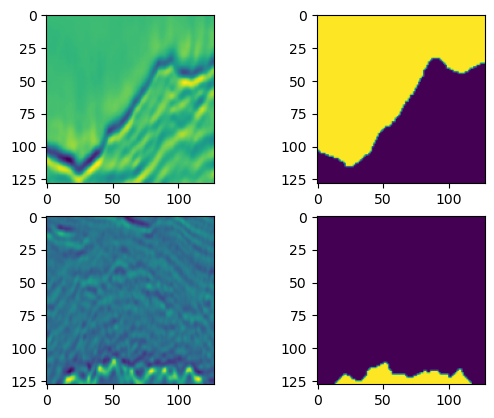

In [8]:
from matplotlib import pyplot as plt

ii=10
plt.subplot(2,2,1)
plt.imshow(train_x2[ii,:,:,0])
plt.subplot(2,2,2)
plt.imshow(train_y2[ii,:,:,0])

ii=6
plt.subplot(2,2,3)
plt.imshow(test_x2[ii,:,:,0])
plt.subplot(2,2,4)
plt.imshow(test_y2[ii,:,:,0])

## Modelling

### Model architechture

This post is part of the simple deep learning series. My objective here is to achieve reasonably good results with a simple model. This helps understand the core concepts related to a particular deep learning task. It's then very possible to gradually include components from state of the art models to achieve better results or a more efficient model.

Before I give you the simplest model architecture for semantic segmentation, I'd like you to spend a bit of time trying to imagine what that would be.

Need help? I'll give you a hint. For semantic segmentation, the width and height of our output should be the same as our input (semantic segmentation is the task of classifying each pixel individually) and the number of channels should be the number of classes to predict.

The simplest model that achieves that is simply a stack of 2D convolutional layers! It's that simple. If you're familiar with image classification, you might remember that you need pooling to gradually reduce the input size on top of which you add a dense layer. For semantic segmentation this isn't even needed because your output is the same size as the input! This very simple model of stacking convolutional layers is called a Fully Convolutional Network (FCN).

Let's see whether this is good enough. We'll be using tf.keras's [sequential API](https://keras.io/api/models/sequential/) to create the model.

In [10]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=train_x2.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=train_y2.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))

2023-01-03 00:15:22.592296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We're not going to bother ourselves with fancy activations, let's just go with relu for the intermediate layers and sigmoid for the last layer. I chose sigmoid for the output because it produces and activation between 0 and 1 (i.e a probability) and our classes are non exclusive, otherwise we could use a softmax along the channels axis.

"Same" padding is perfectly appropriate here, we want our output to be the same size as our input and same padding does exactly that.

I'm not going to claim some sort of magical intuition for the number of convolutional layers or the number of filters. When experimenting for this article, I started with an even smaller model, but it wasn't managing to learn anything. So I gradually increased the size until it started learning.

I've got a deep learning hint for you. If you're ever struggling to find the correct size for your models, my recommendation is to start with something small. If that small model isn't managing to fit the training dataset, then gradually increase the size of your model until you manage to fit the training set. Unless you've made a particularly bad architectural decision, you should always be able to fit your training dataset, if not, your model is probably too small. 

Let's look at how many parameters our model has.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      9

About 75000 trainable parameters. For reference, VGG16, a well known model for image feature extraction contains 138 million parameters. In comparison, our model is tiny. That's good, because it means we should be able to train it quickly on CPU.

Let's choose our training parameters. Adam is my go to gradient descent based optimisation algorithm, I don't want to go into the details of how adam works but it's often a good default that I and [others](https://www.youtube.com/watch?v=JXQT_vxqwIs) recommend.

For the loss function, I chose [binary crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy). This is a good loss when your classes are non exclusive which is the case here. If your labels are exclusive, you might want to look at [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) or something else.

Keras allows you to add metrics to be calculated while the model is training. These don't influence the training process but are useful to follow training performance. Accuracy is often the default, but here accuracy isn't very meaningful. Our classes are so imbalanced (i.e a lot more pixels are background than they are digits) that even a model that always predicts 0 will have a great accuracy. For that reason I added [recall and precision](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall), those metrics are a lot more useful to evaluate performance, especially in the case of a class imbalance.
I was slightly worried that the class imbalance would prevent the model from learning (I think it does a bit at the beginning) but eventually the model learns.

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

### Train and evaluate

Let's train the model for 20 epochs. This takes about 11 minutes on my 2017 laptop with CPU only. If you have GPU available, then use it. Your model will train a lot faster (approx 10x speed depending on your GPU/CPU). If you're familiar with [Google Colab](https://colab.research.google.com/) then then you can also run the notebook version of the tutorial on there and utilise the free GPU/TPU available on the platform (you will need to copy or install the simple_deep_learning package to generate the dataset).

In [13]:
history = model.fit(train_x2, train_y2, epochs=20,
                    validation_data=(test_x2, test_y2))

Epoch 1/20
113/113 [==============================] - 263s 2s/step - loss: 0.5618 - binary_accuracy: 0.7451 - recall: 0.0091 - precision: 0.2682 - val_loss: 0.5372 - val_binary_accuracy: 0.7403 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/20
113/113 [==============================] - 269s 2s/step - loss: 0.4792 - binary_accuracy: 0.7491 - recall: 2.5612e-05 - precision: 0.8293 - val_loss: 0.4823 - val_binary_accuracy: 0.7403 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/20
113/113 [==============================] - 248s 2s/step - loss: 0.4126 - binary_accuracy: 0.8123 - recall: 0.3911 - precision: 0.7392 - val_loss: 0.4293 - val_binary_accuracy: 0.8112 - val_recall: 0.4370 - val_precision: 0.7282
Epoch 4/20
113/113 [==============================] - 271s 2s/step - loss: 0.3717 - binary_accuracy: 0.8504 - recall: 0.5699 - precision: 0.7759 - val_loss: 0.4103 - val_binary_accuracy: 0.8245 - val_recall: 0.5358 - val_precision: 0.7181
Epoch 5/20
113/113 [====

We've stopped the training before the loss plateaued, as you can see, both train and validation loss were still going down after 20 epochs which means that some extra performance might be gained from training longer. However we're not here to get the best possible model.

At the end of epoch 20, on the test set we have an accuracy of 95.6%, a recall of 58.7% and a precision of 90.6%. Remember, these are the metrics for each individual pixel. So the metrics don't give us a great idea of how our segmentation actually looks. To get a better idea, let's look at a few predictions from the test data.

In [14]:
test_y_predicted2 = model.predict(test_x2)

13/13 [==============================] - 5s 378ms/step


In [15]:
train_y_predicted2 = model.predict(train_x2)

113/113 [==============================] - 48s 427ms/step


In [16]:
test_x2.shape

(400, 128, 128, 3)

In [17]:
test_y_predicted2.shape
train_y_predicted2.shape

(3600, 128, 128, 1)

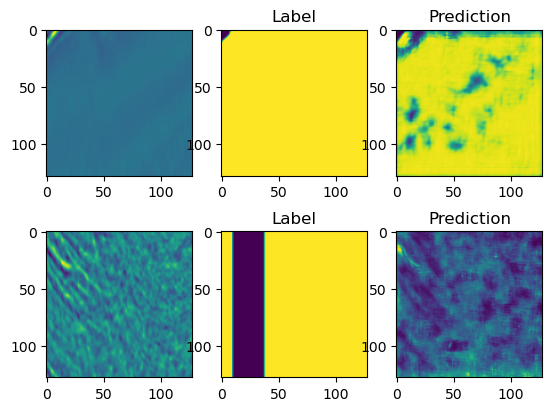

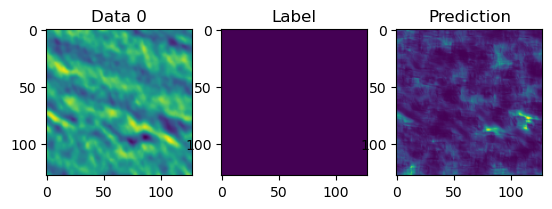

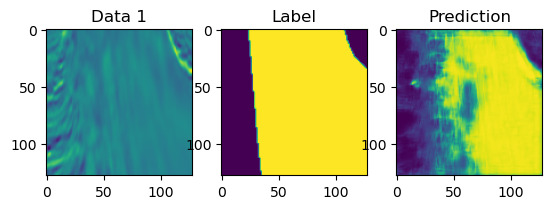

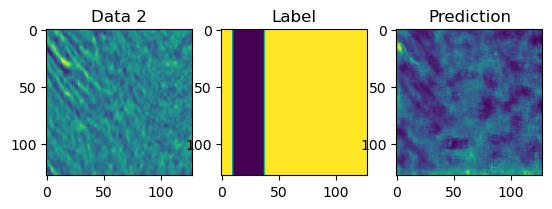

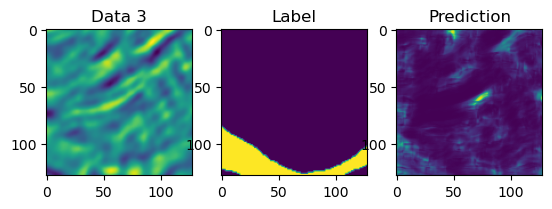

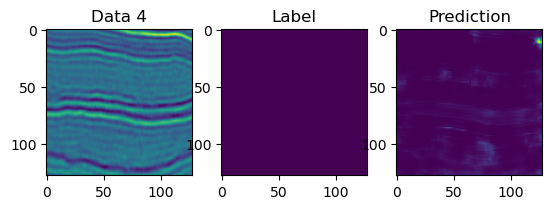

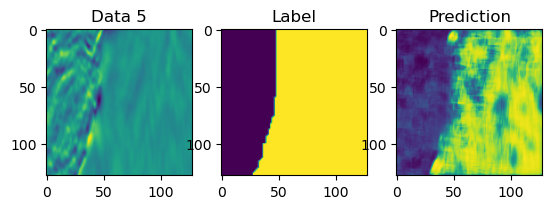

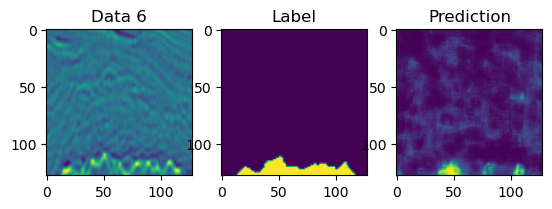

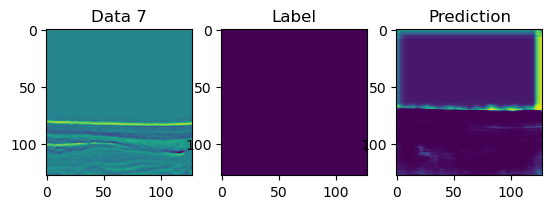

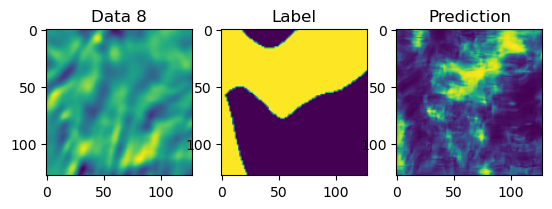

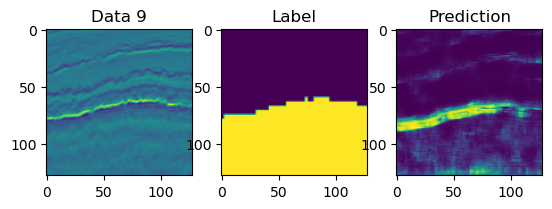

In [20]:
from matplotlib import pyplot as plt

ii=20
plt.subplot(2,3,1)
plt.imshow(train_x2[ii,:,:,0])
plt.subplot(2,3,2)
plt.imshow(train_y2[ii,:,:,0]);plt.title('Label');
plt.subplot(2,3,3)
plt.imshow(train_y_predicted2[ii,:,:,0]);plt.title('Prediction');
ii=2
plt.subplot(2,3,4)
plt.imshow(test_x2[ii,:,:,0]);
plt.subplot(2,3,5)
plt.imshow(test_y2[ii,:,:,0]);plt.title('Label');
plt.subplot(2,3,6);
plt.imshow(test_y_predicted2[ii,:,:,0]);plt.title('Prediction');

for ii in range(10):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(test_x2[ii,:,:,0]);plt.title('Data '+str(ii))
    plt.subplot(1,3,2)
    plt.imshow(test_y2[ii,:,:,0]);plt.title('Label');
    plt.subplot(1,3,3);
    plt.imshow(test_y_predicted2[ii,:,:,0]);plt.title('Prediction');

These randomly selected samples show that the model has at least learnt something. It does quite a good job of detecting the digits but it has some problems. By looking at a few examples, it becomes apparent that the model is far from perfect. In my opinion, this model isn't good enough. There's no overfitting the test dataset so we could train for longer, or increase the size of the model but we can do better than that.

We can improve our model by adding few max pooling layers. The first benefit of these pooling layers is computational efficiency. By reducing the size of the intermediate layers, our network performs fewer computations, this will speed up training a bit. However, the number of parameters remains the same because our convolutions are unchanged. The problem with adding the pooling layers is that our output will no longer have the same height and width the input image. To solve that problem we an use upsampling layers. These simple upsampling layers perform essentially the inverse of the pooling layer. A (2, 2) upsampling layer will transform a (height, width, channels) volume into a (height * 2, width * 2, channels) volume simply by duplicating each pixel 4 times. By applying the same number of upsampling layers as max pooling layers, our output is of the same height and width as the input.

Another, more intuitive, benefit of adding the pooling layers is that it forces the network to learn a compressed representation of the input image. It's not totally evident how this helps but by forcing the intermediate layers to hold a volume of smaller height and width than the input, the network is forced to learn the important elements of the input image as a whole as opposed to simply passing all information through. As you'll see, the pooling layers not only improve computational efficiency but also improve the performance of our model!

This idea of compressing a complex input to a compact representation and using that representation to construct an output is a very common idea in deep learning, such models are often called "encoder-decoder" models. They're not only used in computer vision, in this more [advanced deep learning post](https://awaywithideas.com/keras-implementation-of-a-sequence-to-sequence-model-for-time-series-prediction-using-an-encoder-decoder-architecture/), the author explores the use of encoder-decoders for time series prediction.

In [21]:
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=train_x2.shape[1:], padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D(size=(2, 2)))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(filters=train_y2.shape[-1], kernel_size=(3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision()])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

Epoch 1/20
113/113 [==============================] - 124s 1s/step - loss: 0.5190 - binary_accuracy: 0.7491 - recall: 9.1904e-06 - precision: 0.2128 - val_loss: 0.4569 - val_binary_accuracy: 0.7403 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/20
113/113 [==============================] - 122s 1s/step - loss: 0.4323 - binary_accuracy: 0.7960 - recall: 0.2900 - precision: 0.7391 - val_loss: 0.4371 - val_binary_accuracy: 0.8229 - val_recall: 0.5063 - val_precision: 0.7304
Epoch 3/20
113/113 [==============================] - 129s 1s/step - loss: 0.3936 - binary_accuracy: 0.8271 - recall: 0.4811 - precision: 0.7407 - val_loss: 0.4097 - val_binary_accuracy: 0.8171 - val_recall: 0.5376 - val_precision: 0.6913
Epoch 4/20
113/113 [==============================] - 137s 1s/step - loss: 0.3536 - binary_accuracy: 0.8573 - recall: 0.5894 - precision: 0.7907 - val_loss: 0.4278 - val_binary_accuracy: 0.8297 - val_recall: 0.4617 - val_precision: 0.7976
Epoch 5/20
113/113 [============

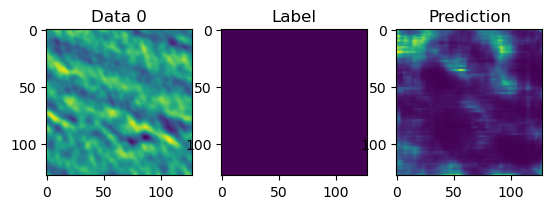

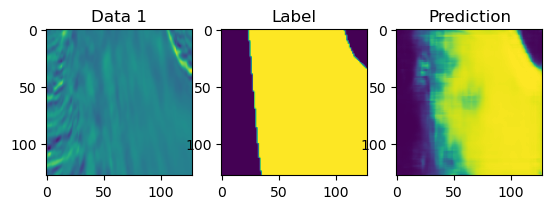

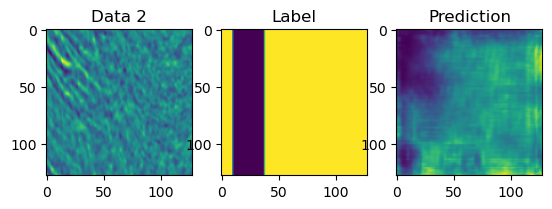

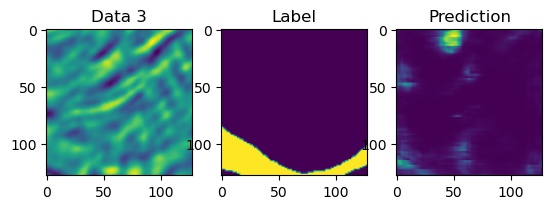

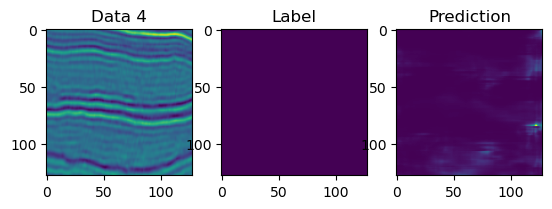

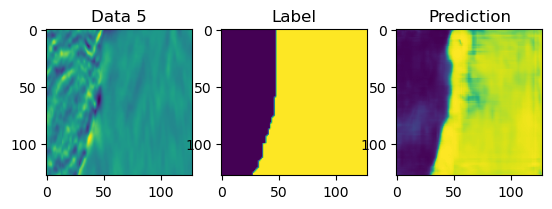

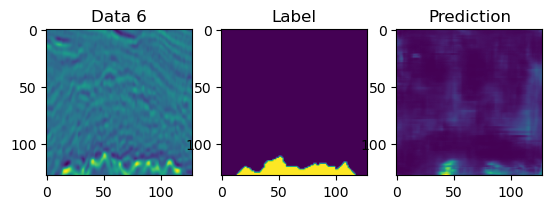

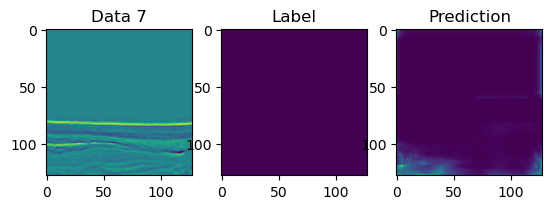

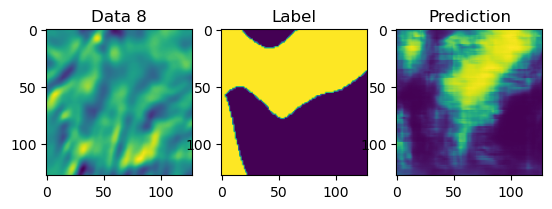

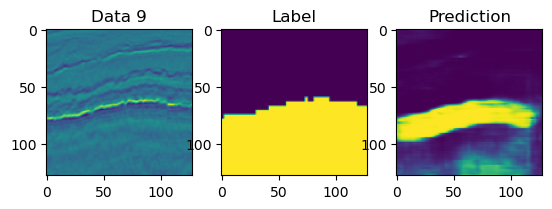

In [23]:
history = model.fit(train_x2, train_y2, epochs=20,
                    validation_data=(test_x2, test_y2))

test_y_predicted2 = model.predict(test_x2)
train_y_predicted2 = model.predict(train_x2)

from matplotlib import pyplot as plt

for ii in range(10):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(test_x2[ii,:,:,0]);plt.title('Data '+str(ii))
    plt.subplot(1,3,2)
    plt.imshow(test_y2[ii,:,:,0]);plt.title('Label');
    plt.subplot(1,3,3);
    plt.imshow(test_y_predicted2[ii,:,:,0]);plt.title('Prediction');

Incredibly, this small modification to our model has allowed us to gain 10 percentage points in recall! The training process also takes about half the time.
Let's see how that looks by displaying the examples we checked earlier.